<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/dayflower_stomata_quantification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepStomata: マルバツユクサ気孔開度測定
<img width=75% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/515e4ef357eff190279765c4a8e67c1024e73f8e041c459f97593356b69961a1.png">

Toda et al., bioRxiv, 2018より

## ライセンス
- DeepStomata: Facial Recognition Technology for Automated Stomatal Aperture Measurement. Toda et al., bioRxiv, 2018.
    - https://www.biorxiv.org/content/10.1101/365098v1
    - CC-BY-NC 4.0 （執筆者本人のものであるため、NCライセンスに関わらず本稿で図の引用をしています）
- 本稿プログラムコード
    - CC-BY-NC4.0

## 解説

気孔は、植物がさまざまな環境刺激に対する生理的反応を研究する上で魅力的なモデルとなります。同時に、背景（表皮細胞や透けて見えるような葉肉組織由来のノイズ）がある程度多様である一方で、その形状は品種内で（比較的）一定の形を保っているため、画像解析技術を利用した気孔の数や開度を測定する題材として適しています。当研究グループでは、マルバツユクサを用いて気孔開度に影響を与える化合物のスクリーニングを行っており、日常的な顕微鏡画像からの気孔開度の手動測定を代替する方法を模索する過程で、DeepStomataが開発されました。

本パイプラインでは、現在で一般的に使用されている深層学習ベースのObject DetectionやSemantic Segmentationは採用していません。代わりに、

1. HOG特徴量とSVM学習器による気孔検出
2. CNNによる気孔の開閉識別
3. scikit-imageのregionpropsを基にした気孔開口領域の解析
といった複数の技術を組み合わせて実現しています。この解析フローを、プログラムコードと共に介します。紹介します。

## 備考
DeepStomataの一部はtensorflow 1.x系でCNNモデルが作成されましたが、現在のcolaboratory環境では1.xが実行できません。そのため、onnx形式に変換し、その実行コードを提供します。

**また、簡潔化やハイパーパラメーターの変更を行っているため、引用論文と同等の結果を保障するものではありません**

本ノートブックはONNXを利用することからGPU環境での実行が推奨されますが、CPU環境でも問題なく実行できる解析速度となっています。

## 実行コード

### 環境設定

In [ ]:
!pip install onnxruntime

In [ ]:
!apt install subversion
!svn export https://github.com/phytometrics/plant_phenotyping_python/trunk/notebooks/assets/deepstomata

### Step by Step 実装

In [ ]:
import dlib
import cv2
import os
import numpy as np
from skimage import feature
import matplotlib.pyplot as plt
import onnxruntime as ort

In [ ]:
image_dir = "/content/drive/MyDrive/phenotyping_temp_assets/examples"
image_files = sorted(os.listdir(image_dir))
print(image_files)

['1.jpg', '10.jpg', '11.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


In [ ]:
# 画像を１枚読み込む
image_file = image_files[0]
path = os.path.join(image_dir, image_file)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#### Step 1. HOG-SVM検出器による気孔座標検出

In [ ]:
def detect(model, image, det_width):
    # 入力画像を縦横比を保ったまま、横幅512pxにリサイズして検出し、
    # 検出された気孔の画像を元のサイズの座標に変換して結果を返します。
    height, width, _ = image.shape
    ratio = width / det_width
    height_det = int(round(height / ratio))
    width_det = int(round(width / ratio))
    scaled_image = cv2.resize(image, dsize=(width_det, height_det))
    _dets = detector(scaled_image)
    dets = []
    # scale back
    for _d in _dets:
        # xmin, ymin, xmax, ymax
        r = [_d.left(), _d.top(), _d.right(), _d.bottom()]
        r = [int(x * ratio) for x in r]
        dets.append(r)
    return dets

[[884, 1730, 1056, 1902], [597, 430, 769, 602], [1142, 674, 1391, 922], [1936, 262, 2142, 468], [1133, 1482, 1338, 1687], [234, 1214, 406, 1386], [1726, 1711, 1898, 1883], [1783, 946, 1955, 1118]]


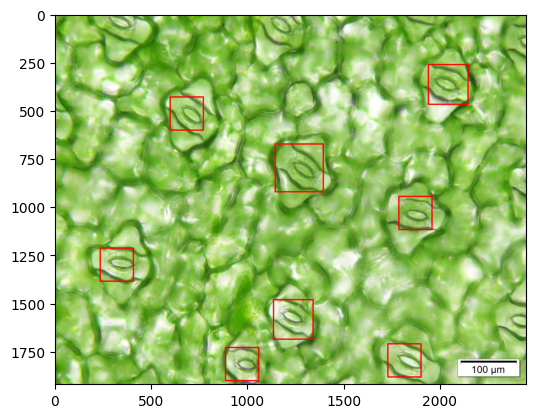

In [ ]:
# 気孔検出器の読み込み
detector_path = "/content/drive/MyDrive/phenotyping_temp_assets/leafdisk161002_c_7.0.svm"
detector = dlib.simple_object_detector(detector_path)

# 推論
dets = detect(detector, image, det_width=512)
print(dets)  # xmin, ymin, xmax, ymaxのnested list

# 結果を描画する。元の画像を編集しないように新たな画像を用意する。
image2 = image.copy()
for det in dets:
    cv2.rectangle(image2, (det[0],det[1]), (det[2],det[3]), (255,0,0), 5)

plt.imshow(image2)

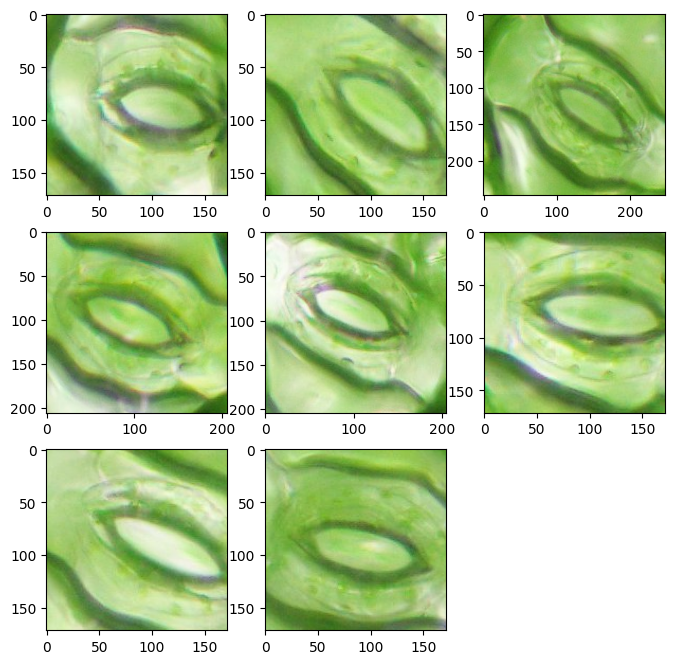

In [ ]:
# 検出した座標をもとに気孔を切り抜くことができます。
plt.figure(figsize=(8,8))
for i, det in enumerate(dets):
    plt.subplot(3,3,i+1)
    stomata = image[det[1]:det[3], det[0]:det[2],:]
    plt.imshow(stomata)

HOG（Histogram of Oriented Gradients）特徴量は、画像の局所的な勾配の方向と強度をヒストグラムとして表現する特徴量です。これまで物体検出や画像認識の分野で広く用いられてきました。dlibではHOG特徴量を用いてSVM（Support Vector Machine）による学習を行い、物体検出を行います。

今回のような入力画像をhog特徴量に使われる勾配として表現すると、以下のような画像が得られます。

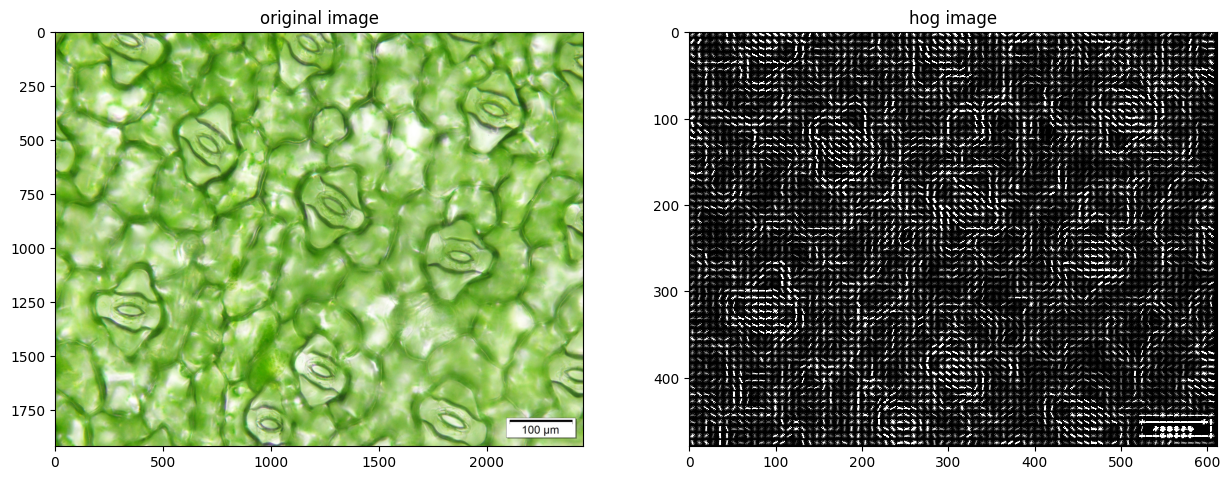

In [ ]:
hog_template = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
hog_template = cv2.cvtColor(hog_template, cv2.COLOR_RGB2GRAY)
_, hog_image = feature.hog(hog_template, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),  block_norm='L2-Hys', visualize=True, transform_sqrt=True)
hog_image *= 255

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(image)
plt.subplot(1,2,2)
plt.title("hog image")
plt.imshow(hog_image, vmax=100, cmap="gray")

ちなみに、気孔検出モデルが探す勾配のイメージは下記のようなものとなります。学習時に様々な方向の気孔を用いているため、検出器は点対称のような勾配模様となります。

<img width=15% src="https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/hogimage.jpg?raw=true">

#### Step2: CNNによる気孔開閉分類（偽陽性判別含む）

In [ ]:
def image_whitening(img):
    img = img.astype(np.float32)
    d, w, h = img.shape
    num_pixels = d * w * h
    mean = img.mean()
    variance = np.mean(np.square(img)) - np.square(mean)
    stddev = np.sqrt(variance)
    min_stddev = 1.0 / np.sqrt(num_pixels)
    scale = stddev if stddev > min_stddev else min_stddev
    img -= mean
    img /= scale
    return img

In [ ]:
# 気孔開閉判定モデルの読み込み
classifier_path = "/content/drive/MyDrive/phenotyping_temp_assets/dscnn.onnx"
providers = ['CPUExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)

# inputとoutputの名前を把握します。
input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

Input names: ['input_image:0']
Output names: ['softmax_output:0']


raw output: [1.00000000e+00 1.28064684e-20 7.02352012e-15 1.57169792e-14]
stat probability: [100.0, 0.0, 0.0, 0.0]
index with most highest value: 0
stomata state: open


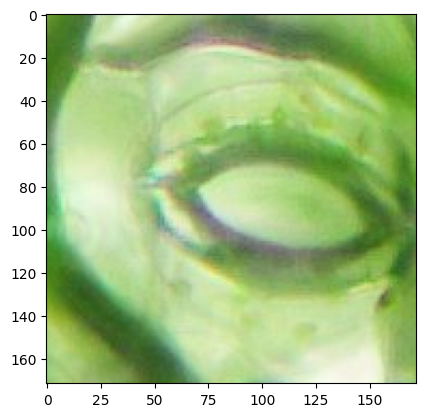

In [ ]:
state_string = ["open", "closed", "partially open", "False Positive"]

# 前の検出器の推論で得られた気孔の座標detsを再利用します。
# １つ目の検出座標だけ使います。
d = dets[0]
# 気孔の切り出し
stomata = image[d[1]:d[3], d[0]:d[2], :]

# CNNのための画像の前処理
_stomata = stomata.copy()
_stomata = cv2.resize(_stomata, dsize=(56,56))
_stomata = image_whitening(_stomata)
_stomata = np.expand_dims(_stomata, axis=0)
# CNNによる推論
prediction = ort_session.run(["softmax_output:0"], {"input_image:0": _stomata})[0][0]

# 結果の表示
plt.imshow(stomata)
print("raw output:", prediction)
print("stat probability:", [np.round(x*100,3) for x in prediction])
idx = np.argmax(prediction)
print("index with most highest value:", idx)
print("stomata state:", state_string[idx])

この訓練済みCNNで得られる出力は、入力画像（気孔）に対する

**開口状態スコア, 閉鎖状態スコア, 部分開口状態スコア,　気孔ではない状態スコア**です。

CNN内部のsoftmax関数によって４つの状態の累計が１となるように調整されているので、値に100をかけることで、◯◯という状態である確率と解釈することができます。

上記の結果の場合、開口気孔である確率が100%との結果を得ることができました。

#### Step3: regionpropsモジュールを利用した気孔開口領域の計算

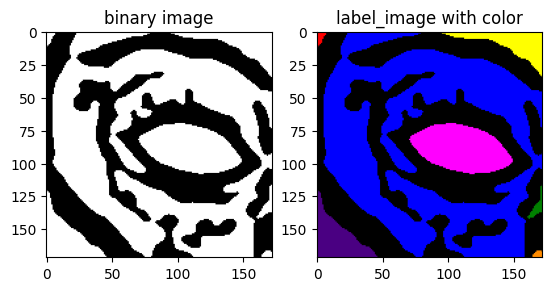

In [ ]:
from skimage.filters import gaussian, threshold_local
from skimage.measure import label, regionprops
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_local
from skimage.morphology import binary_opening, binary_closing
from skimage.morphology import remove_small_holes
# from scipy.ndimage import gaussian_filter

_stomata = stomata.copy()
_stomata = rgb2gray(_stomata)
_stomata = gaussian(_stomata, sigma=3)
# _stomata = gaussian_filter(_stomata, sigma=3)
local_thresh = threshold_local(_stomata, 31, method="gaussian")
_stomata = _stomata > local_thresh
_stomata = binary_opening(_stomata)
_stomata = binary_closing(_stomata)

_stomata = remove_small_holes(_stomata, area_threshold=200)


lbl_image = label(_stomata)
_lbl = label2rgb(lbl_image)

plt.subplot(1,2,1)
plt.title("binary image")
plt.imshow(_stomata, cmap="gray")

plt.subplot(1,2,2)
plt.title("label_image with color")
plt.imshow(_lbl)

異なる色が異なるラベル領域を表しています。前項の種子解析と同様に、regionpropsで形状をとれば面積や開度（短軸長）が求まるでしょう。ただし、気孔開口領域ではない領域のフィルタリングをしなければなりません。ここで、

1. 一般に気孔開口領域は楕円であること、
2. 検出器をつかっていることから、画面中央寄りに気孔開口領域があること
3. 面積の下限、上限もある程度きまっていそうなこと。

このような条件をもとにregionpropsで得られる値をフィルタリングします。

initial prop no.: 7
filtered_props: 1


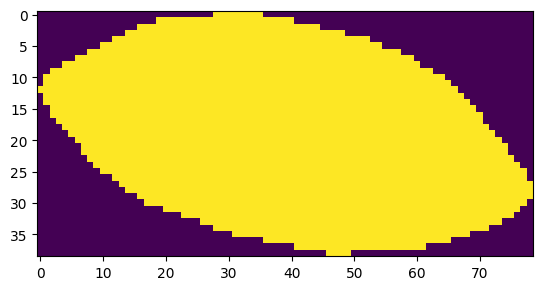

In [ ]:
props = regionprops(lbl_image)
# フィルタ前領域数
print("initial prop no.:", len(props))

# ラムダ式を用いて条件に合致するかの式を完結に書くことができます。

criteria = [
    lambda r: r.area > 100,
    lambda r: r.area < 6000,
    lambda r: r.solidity > 0.8,
    lambda r: r.axis_major_length > 40,
    lambda r: r.extent > 0.5,
]

# 全部がtrueのものののみ残す
filtered_props = [r for r in props if all(criterion(r) for criterion in criteria)]
print("filtered_props:", len(filtered_props))

# 残った領域を描画する。regionpropsのimage attributeは単一ラベル領域のみの画像を保持する。
plt.imshow(filtered_props[0].image)

開口領域のみ抽出できました。
ここで、気孔開口領域と気孔開度は、それぞれラベル領域の面積と短軸長と等しいため、
下に示すコードで求めることができます。


In [ ]:
print("stomatal pore area:", filtered_props[0].area)
print("stomatal aperture:", filtered_props[0].axis_minor_length)

stomatal pore area: 2098
stomatal aperture: 35.17532162044048


### End to End 実装

In [ ]:
import dlib
import onnxruntime
import cv2
import os
import numpy as np
import pandas as pd
from skimage import feature
from skimage.filters import gaussian, threshold_local
from skimage.measure import label, regionprops
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_local
from skimage.morphology import binary_opening, binary_closing

import matplotlib.pyplot as plt
import onnxruntime as ort

In [ ]:
image_dir = "/content/deepstomata/examples"
image_files = sorted(os.listdir(image_dir))

classifier_path = "/content/deepstomata/dscnn.onnx"
detector_path = "/content/deepstomata//leafdisk161002_c_7.0.svm"

state_string = ["open", "closed", "partially open", "False Positive"]

criteria = [
    lambda r: r.area > 100,
    lambda r: r.area < 6000,
    lambda r: r.solidity > 0.8,
    lambda r: r.axis_major_length > 40,
    lambda r: r.extent > 0.5,
]

In [ ]:
# 気孔検出器の読み込み
detector = dlib.simple_object_detector(detector_path)
# 気孔開閉判定モデルの読み込み
providers = ['CPUExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)

In [ ]:
def image_whitening(img):
    img = img.astype(np.float32)
    d, w, h = img.shape
    num_pixels = d * w * h
    mean = img.mean()
    variance = np.mean(np.square(img)) - np.square(mean)
    stddev = np.sqrt(variance)
    min_stddev = 1.0 / np.sqrt(num_pixels)
    scale = stddev if stddev > min_stddev else min_stddev
    img -= mean
    img /= scale
    return img

def detect(model, image, det_width):
    # 入力画像を縦横比を保ったまま、横幅512pxにリサイズして検出し、
    # 検出された気孔の画像を元のサイズの座標に変換して結果を返しています。
    height, width, _ = image.shape
    ratio = width / det_width
    height_det = int(round(height / ratio))
    width_det = int(round(width / ratio))
    scaled_image = cv2.resize(image, dsize=(width_det, height_det))
    _dets = detector(scaled_image)
    dets = []
    # scale back
    for _d in _dets:
        # xmin, ymin, xmax, ymax
        # ratioをかけることで元の座標に対応する検出位置を求めるとともに、
        # ratioをかけることで画像サイズの外側に座標が来てしまうことを未然に防ぐ
        r = [
            np.max([0, int(_d.left()*ratio)]),
            np.max([0,int(_d.top()*ratio)]),
            np.min([width, int(_d.right()*ratio)]),
            np.min([height,int(_d.bottom()*ratio)])
            ]


        dets.append(r)
    return dets

def filter_pore(stomata, criteria):
    stomata = rgb2gray(stomata)
    stomata = gaussian(stomata, sigma=7)
    local_thresh = threshold_local(stomata, 31, method="gaussian")
    stomata = stomata > local_thresh
    stomata = binary_opening(stomata)
    stomata = binary_closing(stomata)
    stomata = remove_small_holes(stomata, area_threshold=200)
    lbl_image = label(stomata)

    props = regionprops(lbl_image)
    filtered_props = [r for r in props if all(criterion(r) for criterion in criteria)]
    return filtered_props

def measure_pore(stomata, idx, criteria):
    # area, apertureを戻値とする
    # 0と測定不能のNoneは違うことに注意

    # 閉鎖気孔の場合、開度も面積も0
    if idx ==1:
        return 0, 0
    # False Positiveの場合、None, None
    elif idx == 3:
        return None, None
    # 開口気孔の場合 i.o.w. idx == 0 or idx ==2
    else:
        stomata = rgb2gray(stomata)
        stomata = gaussian(stomata, sigma=7)
        local_thresh = threshold_local(stomata, 31, method="gaussian")
        stomata = stomata > local_thresh
        stomata = binary_opening(stomata)
        stomata = binary_closing(stomata)
        stomata = remove_small_holes(stomata, area_threshold=200)
        lbl_image = label(stomata)
        # plt.imshow(label2rgb(lbl_image))
        # plt.show()
        props = regionprops(lbl_image)
        try:
            filtered_props = [r for r in props if all(criterion(r) for criterion in criteria)]
        except Expception as e:
            return None, None

        # １つ絞りきれない、もしくは何ものこらなかった場合
        if len(filtered_props) != 1:
            return None, None

        # 1つのみ候補がのこった場合
        else:
            return filtered_props[0].area, filtered_props[0].axis_minor_length

In [ ]:
result = []

for image_file in image_files:
    path = os.path.join(image_dir, image_file)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 気孔検出推論
    dets = detect(detector, image, det_width=512)
    # 結果描画。
    annotated = image.copy()
    for det in dets:
        cv2.rectangle(annotated, (det[0],det[1]), (det[2],det[3]), (255,0,0), 5)

    # 気孔開閉判定
    for det in dets:
        #結果を格納する際の初期値
        area = None
        aperture =None

        orig_stomata = image[det[1]:det[3], det[0]:det[2], :]
        stomata = orig_stomata.copy()
        stomata = cv2.resize(stomata, dsize=(56,56))
        stomata = image_whitening(stomata)
        stomata = np.expand_dims(stomata, axis=0)
        prediction = ort_session.run(["softmax_output:0"], {"input_image:0": stomata})[0][0]
        idx = np.argmax(prediction)
        area, aperture = measure_pore(orig_stomata, idx, criteria)
        #結果をresultに追加
        r = [image_file, idx, area, aperture]
        result.append(r)

In [ ]:
df = pd.DataFrame(result, columns=["file","stat", "area","aperture"])
df2 = df.dropna()
df2

,file,stat,area,aperture
0,1.jpg,0,1861.0,32.585372
1,1.jpg,0,2655.0,35.033039
3,1.jpg,0,2596.0,35.349715
4,1.jpg,0,2086.0,30.394982
5,1.jpg,0,2697.0,33.162578
7,1.jpg,0,2234.0,30.359076
9,10.jpg,1,0.0,0.000000
11,10.jpg,1,0.0,0.000000
12,10.jpg,1,0.0,0.000000
13,10.jpg,1,0.0,0.000000


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='file', ylabel='area'>

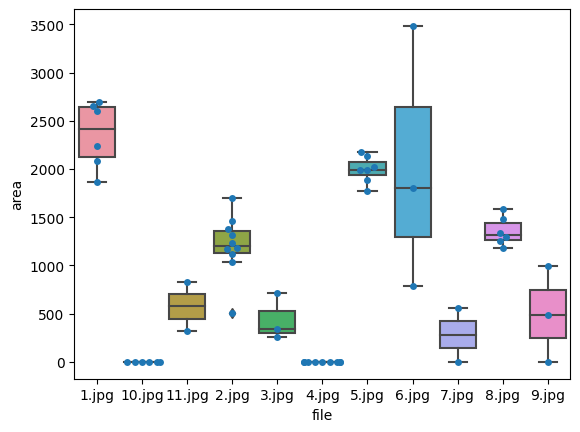

In [ ]:
import seaborn as sns
sns.boxplot(df2, x="file", y="area")
sns.swarmplot(df2, x="file", y="area")